In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf

/Users/paulag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array(nino34['nino34'].values)

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


In [4]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [5]:
oni = ONI(nino34)

In [6]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [7]:
clm = climatology(nino34)

In [8]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [9]:
anm = SST_anomaly(nino34, clm)
oanm = ONI(anm)

# Data Preparation

In [10]:
T = 7      # prediction timeline
H = 48   # history used for prediction
include_month = 1           # 1 if we use the month as a feature, 0 otherwise
threshold = 0.5         
signal = np.array(nino34[12 * 50:])   # data used for training/testing
length = signal.shape[0]    # number of data points

In [275]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H + include_month))
for i in range(size):
    if(include_month == False):
         data[i] = signal[i:(i + H)]
    else:
        data[i] = np.append(signal[i:(i + H)], (i + H + T) % 12)

labels = np.ndarray((size), dtype = np.float64)
        
for i in range(size):
    labels[i] = oanm[i + H + T]

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])
        
mean = np.mean(train, axis = 0)
std = np.std(train, axis = 0)

train_n = np.divide(
        train - np.outer(np.ones(train.shape[0]), mean),
        np.outer(np.ones(train.shape[0]), std))

val_n = np.divide(
        val - np.outer(np.ones(val.shape[0]), mean),
        np.outer(np.ones(val.shape[0]), std))

test_n = np.divide(
        test - np.outer(np.ones(test.shape[0]), mean),
        np.outer(np.ones(test.shape[0]), std))

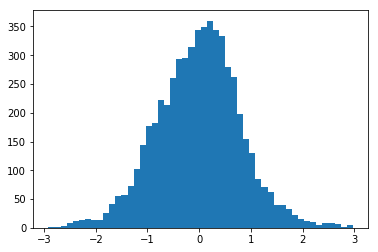

In [276]:
plt.hist(train_labels, bins=50);

# Simple Model

In [262]:
mse = {}
mae = {}

for N1 in [H * 4, H * 8, H * 16]:
    for N2 in [H * 8, H * 16]:
        for N3 in [H * 8, H * 16, H * 32]:
            for d in [0, 0.2, 0.5]:
                for e in [50, 60, 70]:
                    model = tf.keras.models.Sequential([
                      tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                      tf.keras.layers.Dropout(d),
                      tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                      tf.keras.layers.Dropout(d),
                      tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                      tf.keras.layers.Dropout(d),
                      tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
                    ])

                    model.reset_states()

                    model.compile(optimizer='adam',
                        loss='mae',
                        metrics=['mse', 'mae'])

                    model.fit(train_n, train_labels, epochs = e, verbose = 0)
                    (loss, mse[(N1, N2, N3, d, e)], mae[(N1, N2, N3, d, e)]) = model.evaluate(val_n, val_labels, verbose = 0)
    
                    print(N1, N2, N3, d, e, mse[(N1, N2, N3, d, e)], mae[(N1, N2, N3, d, e)])

192 384 384 0 50 0.4037404016954224 0.465830109199556
192 384 384 0 60 0.3413516728817916 0.4191293514409319
192 384 384 0 70 0.31750335796874446 0.42007149534733024
192 384 384 0.2 50 0.39742260453413847 0.4552851058855778
192 384 384 0.2 60 0.3587530150133021 0.4357964748761901
192 384 384 0.2 70 0.31361871640555333 0.4041263921921994
192 384 384 0.5 50 0.43360490792271805 0.48044231926359715
192 384 384 0.5 60 0.34594426836286274 0.42788954200197
192 384 384 0.5 70 0.34352108644170254 0.43077987165344195
192 384 768 0 50 0.3722952138476011 0.4450346204747005
192 384 768 0 60 0.370505622455052 0.44706889678116274
192 384 768 0 70 0.31908153853162663 0.40983140268245666
192 384 768 0.2 50 0.35700932370514427 0.4296248703777623
192 384 768 0.2 60 0.32534662014296073 0.4188280793465152
192 384 768 0.2 70 0.3318281602792713 0.4146259600708799
192 384 768 0.5 50 0.3572257019224621 0.4421934747562355
192 384 768 0.5 60 0.32675671677629486 0.4124589432187441
192 384 768 0.5 70 0.30857930580

KeyboardInterrupt: 

In [263]:
best_models = {k:v for (k,v) in mse.items() if v < 0.3}
print(best_models)

{(192, 768, 768, 0.2, 70): 0.2991505854603957, (192, 768, 768, 0.5, 70): 0.265876918363304, (192, 768, 1536, 0, 70): 0.2901690027126077, (192, 768, 1536, 0.5, 70): 0.27977027245262426}


In [277]:
(N1, N2, N3, d) = (192, 768, 768, 0.5)
epochs = 80

model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(1,  kernel_initializer='normal', activation = 'linear')
        ])

model.reset_states()

model.compile(optimizer='adam',
                    loss='mae',
                    metrics=['mse', 'mae'])

model.fit(train_n, train_labels, epochs = epochs, verbose = 0)
(loss, mse, mae) = model.evaluate(val_n, val_labels, verbose = 0)

print(mse, mae)

0.190172762221315 0.29459065607949797


In [278]:
pred = model.predict(train_n)

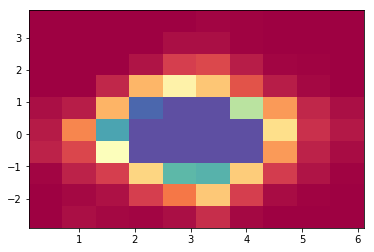

In [279]:
plt.hist2d(oanm[train_ind] + 3, pred[:,0], cmap = plt.cm.Spectral, vmax = 200);

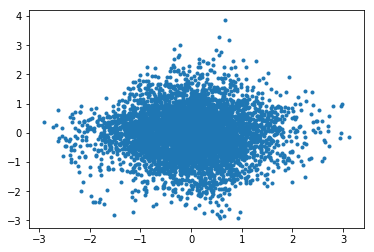

In [280]:
plt.plot(oanm[train_ind], pred[:,0], ".");

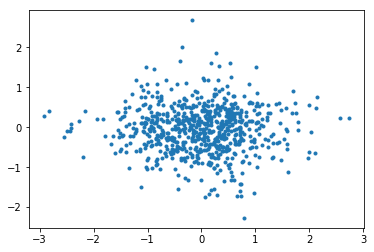

In [281]:
pred_val = model.predict(val_n)
plt.plot(oanm[val_ind], pred_val[:,0], ".");

# Simple Regressors

In [282]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor()
model.fit(train_n,train_labels)

# Get the mean absolute error on the validation data
predicted = model.predict(val_n)
MAE = mean_absolute_error(val_labels , predicted)
MSE = mean_squared_error(val_labels , predicted)
print(MAE, MSE)

0.6176734146537877 0.6202964910510118


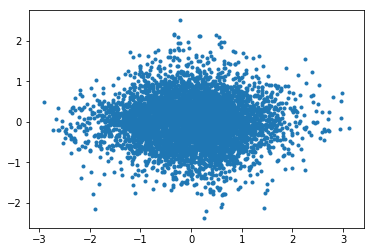

In [283]:
plt.plot(oanm[train_ind], model.predict(train_n), ".");

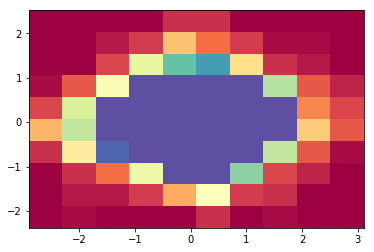

In [284]:
plt.hist2d(oanm[train_ind], model.predict(train_n), cmap = plt.cm.Spectral, vmax = 50);

In [285]:
from sklearn import svm

model = svm.SVR()
model.fit(train_n,train_labels)

predicted = model.predict(val_n)
MAE = mean_absolute_error(val_labels , predicted)
MSE = mean_squared_error(val_labels , predicted)

print(MAE, MSE)

0.5938722116974713 0.5962853868385536


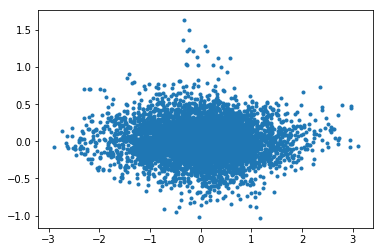

In [286]:
plt.plot(oanm[train_ind], model.predict(train_n), ".");

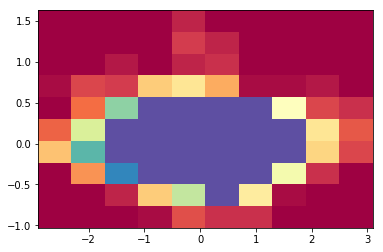

In [287]:
plt.hist2d(oanm[train_ind], model.predict(train_n), cmap = plt.cm.Spectral, vmax = 50);